In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [2]:
df= pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')
df1= pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv')

**About Dataset **

Age : Age of the patient

Sex : Sex of the patient

exang: exercise induced angina (1 = yes; 0 = no)

ca: number of major vessels (0-3)

cp : Chest Pain type chest pain type

Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4: asymptomatic
trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach : maximum heart rate achieved

target : 0= less chance of heart attack 1= more chance of heart attack

In [3]:
df.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [4]:
df1.head()

98.6
0  98.6
1  98.6
2  98.6
3  98.1
4  97.5

# **EDA**

Let's start with exploring the features which influence the output 


Data types of df

In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [6]:
#checking for null values

df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [7]:
df.output.value_counts()

1    165
0    138
Name: output, dtype: int64

In [8]:
df.tail()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
298    0      3       0  
299    0      3       0  
300    2      3       0  
301    1      3       0  
302    1      2       0

In [9]:
df.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [10]:
df1.shape

(3585, 1)

Checking the correlation between the features using mutual information

Output is our target variable

In [11]:
X= df.drop('output',axis=1)
y= df.output

# Mutual Information

In [12]:
#using mutual_info_classif for classification problem MI
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

exng        0.171299
thall       0.157050
cp          0.147017
caa         0.131002
thalachh    0.100778
chol        0.073801
oldpeak     0.070888
slp         0.046030
sex         0.043967
trtbps      0.017286
restecg     0.008926
age         0.006276
fbs         0.000000
Name: MI Scores, dtype: float64

cp, thall, exng, slp and caa are the top 5 features which are dependant with output feature.

Age, trtbps and restecg does not have any dependancy.

We'll train and test with top 6 features and test the accuracy and then with all the features and test the accuracy and auc score

# Test train split

In [13]:
from sklearn.model_selection import train_test_split

# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

# Minmax scaling 

In [14]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

Lets start with **decision tree**

# Decison Tree

1. With top 7 features

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#assigning the features under a list

features=['thall','caa','cp','oldpeak','exng','chol','thalachh']
X= df[features]
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

tree_model= DecisionTreeClassifier(random_state=1)
tree_model.fit(X_train, y_train)
preds= tree_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))


ACCURACY:  70.49180327868852
AUC score:  0.7009803921568628


2. Let's try with all features

In [16]:
X= df.drop('output',axis=1)
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

tree_model= DecisionTreeClassifier(random_state=1)
tree_model.fit(X_train, y_train)
preds= tree_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  77.04918032786885
AUC score:  0.767429193899782


The accuracy and AUC has improved when we train with all the features in decision tree model. 

Next we'll make use of the parameters in decision tree model

3. Decision tree with parameter tuning with all features included

In [17]:
X= df.drop('output',axis=1)
y= df.output

depth = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
leaf=[1, 5, 10, 15, 20, 500, 100, 200]
scores=[]
for d in depth:
      for l in leaf:
        dmodel = DecisionTreeClassifier(random_state=0,max_depth=d,min_samples_leaf=l)
        dmodel.fit(X_train, y_train)

        pred1 = dmodel.predict(X_val)
        acc= accuracy_score(y_val,pred1)*100
        auc = roc_auc_score(y_val,pred1)
        #print('%4s %s -> auc %.3f accuracy  %.2f' % (d, l, auc, acc))

        scores.append((d,l,auc))

In [18]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

pivot2 = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
pivot2.round(3)

auc                                                   \
max_depth           NaN   1.0    2.0    3.0    4.0    5.0    6.0    10.0   
min_samples_leaf                                                           
1                 0.749  0.686  0.756  0.738  0.778  0.749  0.727  0.749   
5                 0.808  0.686  0.756  0.738  0.808  0.808  0.808  0.808   
10                0.738  0.686  0.756  0.738  0.738  0.738  0.738  0.738   
15                0.756  0.686  0.756  0.756  0.756  0.756  0.756  0.756   
20                0.756  0.686  0.756  0.756  0.756  0.756  0.756  0.756   
100               0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500   
200               0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500   
500               0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500   

                                
max_depth          15.0   20.0  
min_samples_leaf                
1                 0.749  0.749  
5                 0.808  0.808  
10                0.738  0.738  
15                0.756  0.756  
20                0.756  0.756  
100               0.500  0.500  
200               0.500  0.500  
500               0.500  0.500

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

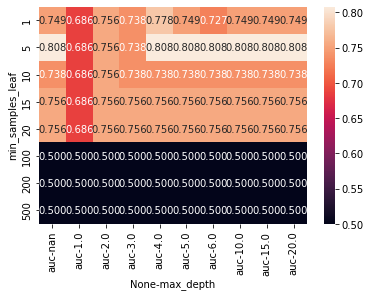

In [19]:
import seaborn as sns
sns.heatmap(pivot2, annot=True, fmt=".3f")

We are getting high auc score when min_samples_leaf=5 and max_depth to be between 4-20 since we have same auc score
Finalizing parameters


In [20]:
#finalized decision tree model
X= df.drop('output',axis=1)
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

tree_model= DecisionTreeClassifier(random_state=1,max_depth=5,min_samples_leaf=5)
tree_model.fit(X_train, y_train)
preds= tree_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  80.32786885245902
AUC score:  0.8082788671023965


With parameter tuning, results are getting worse, so we'll go with default one

# Random forest

4. **Random forest** classifier with top 7 features

In [21]:
from sklearn.ensemble import RandomForestClassifier

X= df[features]
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  85.24590163934425
AUC score:  0.8523965141612201


5. **Random forest** with all features

In [22]:
X= df.drop('output',axis=1)
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  83.60655737704919
AUC score:  0.8376906318082789


In Random forest, model trained with top 7 features gives higher accuracy and auc score

6. Random forest with parameter tuning with top 7 features included 

In [23]:
X= df[features]
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

#determing depth
depth=[5,10,15,20]
score=[]
score1=[]
for d in depth:
       for n in range(10,201,10):


        rmodel = RandomForestClassifier(n_estimators=n,random_state=1,max_depth=d)
        rmodel.fit(X_train, y_train)

        pred = rmodel.predict(X_val)
        acc= accuracy_score(y_val,pred)*100
        auc = roc_auc_score(y_val,pred)

        #print('%4s %s  %.2f %.3f'%(n,d,acc,auc))
        score.append((d,n,auc))
        
#creating dataframe
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(score, columns=columns)
        

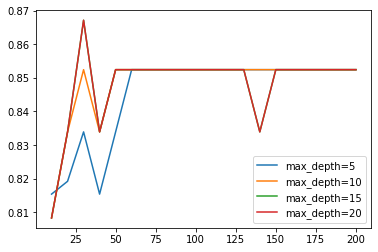

In [24]:
import matplotlib.pyplot as plt
for d in depth:
    subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(subset.n_estimators, subset.auc,label='max_depth=%d' % d)

plt.legend()

choosing max depth= 20 and we get highest auc score with that depth

In [25]:
depth= 20
#getting samples
score1=[]

samples=[1,5,10,25,30,50]
for s in samples:
       for n in range(10,201,10):


        rmodel = RandomForestClassifier(n_estimators=n,random_state=1,max_depth=depth,min_samples_leaf=s)
        rmodel.fit(X_train, y_train)

        pred = rmodel.predict(X_val)
        acc= accuracy_score(y_val,pred)*100
        auc = roc_auc_score(y_val,pred)

        #print('%4s %s  %.2f %.3f'%(n,d,acc,auc))
        #score.append((d,n,acc))
        score1.append((s,n,auc))
        
        
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(score1, columns=columns)

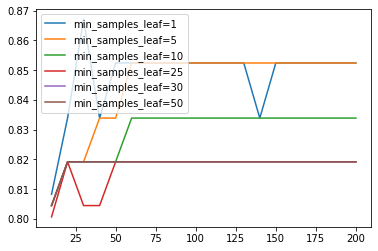

In [26]:
for s in samples:
    subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(subset.n_estimators, subset.auc,
             label='min_samples_leaf=%d' % s)

plt.legend()

We are reaching maximum auc score when min_samples_leaf=1, with estimators between 25-40

In [27]:
## finalized paramter values 

X= df[features]
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(n_estimators=27,random_state=11,max_depth=20,min_samples_leaf=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  86.88524590163934
AUC score:  0.8709150326797386


Accuracy and auc score has slightly increased with parameter tuning

# XGB classifer

7. **XGB classifer** with top 7 features

In [28]:
from xgboost import XGBClassifier

X= df[features]
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  83.60655737704919
AUC score:  0.841503267973856


8. XCB classifier with all features

In [29]:
X= df.drop('output',axis=1)
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  83.60655737704919
AUC score:  0.8338779956427016


Results were almost same for XGB classifier for both categories. We'll take with top 7 features as it give a higher auc score and apply parameter tuning

9. XCB model with parameter tuning with top 7 features

In [30]:
X= df[features]
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

estimators=[50,100,150,200,250,300]
depth=[2,3,4,5,6]

score=[]
score1=[]

for d in depth:
     for n in estimators:
        xgb_model = XGBClassifier(learning_rate=0.05,n_estimators=n,max_depth=d)

        xgb_model.fit(X_train, y_train)
        prediction_xgb = xgb_model.predict(X_val)
        acc= accuracy_score(y_val,prediction_xgb)*100
        auc = roc_auc_score(y_val,prediction_xgb)

        score1.append((n,d,auc))
        
        
#making it as dataframe
columns = ['n_estimators', 'max_depth', 'auc']
df_scores = pd.DataFrame(score1, columns=columns)

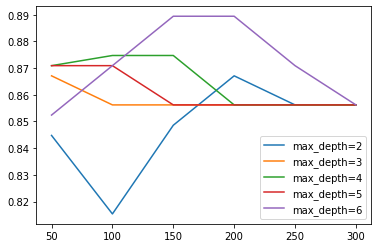

In [31]:
for d in depth:
    subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(subset.n_estimators, subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [32]:
#picking max_depth=6 and estimators range between 150-200 --> 190

X= df[features]
y= df.output

X= scale(X)
X_train,X_val,y_train,y_val= dataset(X,y)

xgb_model = XGBClassifier(learning_rate=0.05,n_estimators=190,max_depth=6)
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  88.52459016393442
AUC score:  0.8894335511982572


# Selecting Final model

**Model scores after parameter tuning**

***Decison tree***

ACCURACY:  80.32786885245902

AUC score:  0.8082788671023965

***Random forest***

ACCURACY:  86.88524590163934

AUC score:  0.8709150326797386

***XGB classifier***

**ACCURACY:  88.52459016393442**

**AUC score:  0.8894335511982572**

Finalizing XCB classifier model as final model

In [33]:
#training with 80% of data --> X_full_train

X= df[features]
y= df.output

train_full_X,test_X, train_full_y, test_y = train_test_split(X, y,test_size=0.2,random_state = 0)

X= scale(X)


xgb_model = XGBClassifier(learning_rate=0.05,n_estimators=190,max_depth=6)
xgb_model.fit(train_full_X, train_full_y)
prediction_xgb = xgb_model.predict(test_X)

print('ACCURACY: ',accuracy_score(test_y, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(test_y,prediction_xgb))

ACCURACY:  83.60655737704919
AUC score:  0.8300653594771241


**Results with test data**

ACCURACY:  98.36065573770492

AUC score:  0.9722222222222222